In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

from fbprophet import Prophet

style.use('seaborn-poster') #sets the size of the charts
style.use('fivethirtyeight')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [33]:
# load data
train = pd.read_csv("../input/train.csv")
print(train.head())
print(train.shape)

train['date'] = pd.to_datetime(train['date'])

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
(913000, 4)


In [34]:
# how many stores? how many item per store?
print(len(train.store.unique()))
print(train.store.unique())
# 10 stores

10
[ 1  2  3  4  5  6  7  8  9 10]


Text(0.5,1,'Sales of one item')

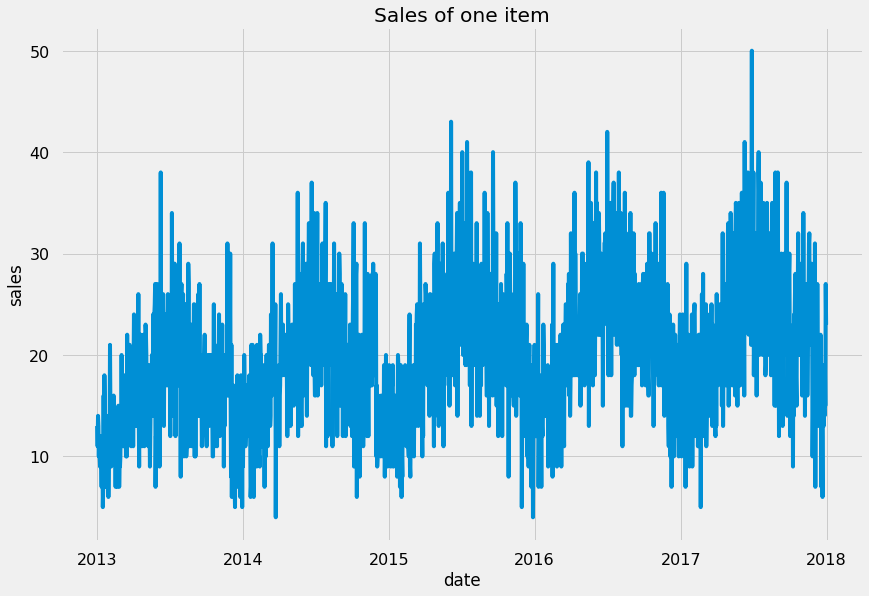

In [55]:
# plot example
store11 = train[(train.store==1) & (train.item==1)]
sns.lineplot(x='date', y='sales', data=store11).set_title("Sales of one item")

Text(0.5,1,'Sales of different items')

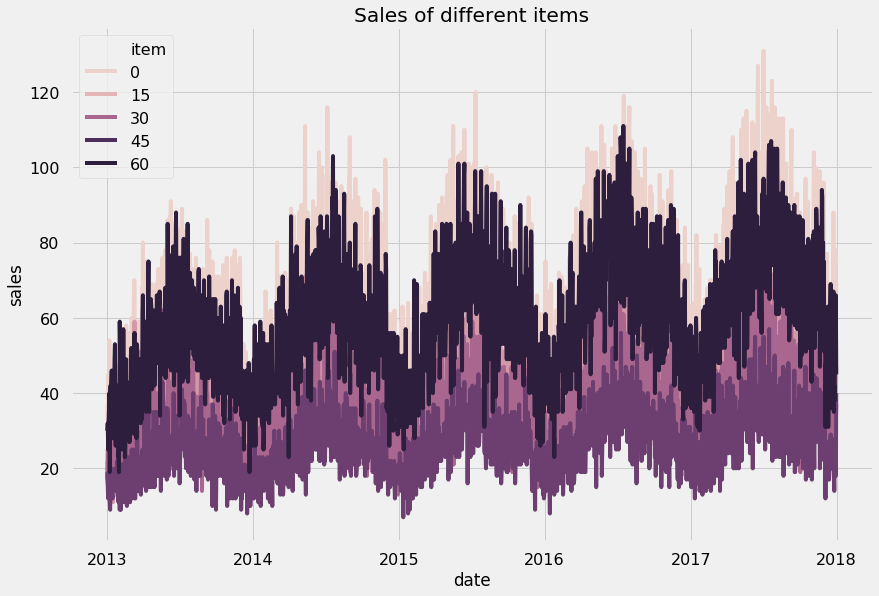

In [56]:
store15 = train[(train.store==1) & (train.item.isin([10,20,30,40,50]))]
sns.lineplot(x='date', y='sales', hue='item', data = store15).set_title("Sales of different items")

Text(0.5,1,'Sales in one year')

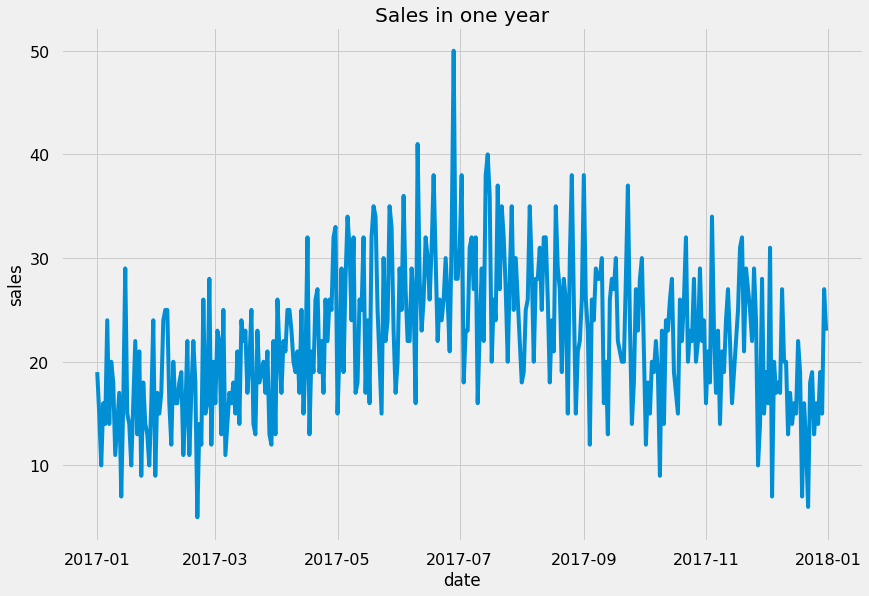

In [57]:
# subset inside a smaller time interval
store11_subset = store11[store11.date >= "2017-01-01"]
sns.lineplot(x='date', y='sales', data=store11_subset).set_title("Sales in one year")

Text(0.5,1,'Boxplot across months')

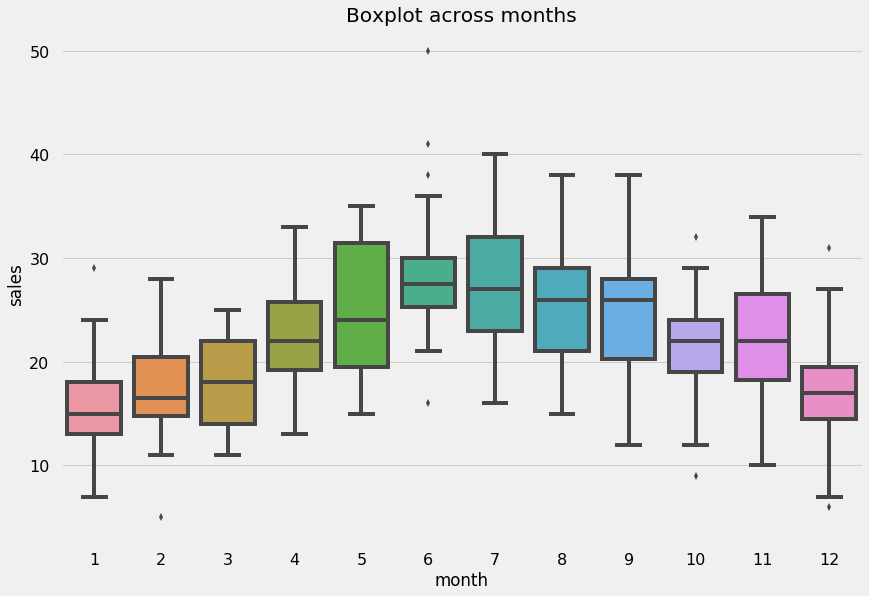

In [58]:
# boxplot distribution across months
store_bp = store11_subset.copy()
store_bp['month'] = store_bp.date.apply(lambda x: x.month)
sns.boxplot(store_bp.month, store_bp.sales).set_title("Boxplot across months")

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Sales Distribution')

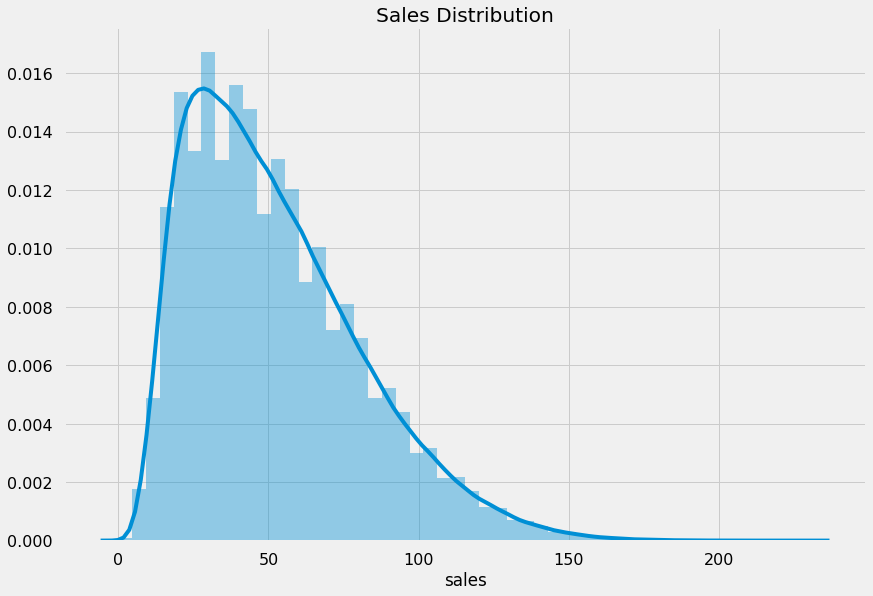

In [59]:
# distribution of total sales
sns.distplot(train.sales).set_title("Sales Distribution")

In [65]:
# prophet model
df = store11.copy()
df.drop(['store', 'item'], axis=1, inplace=True)
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


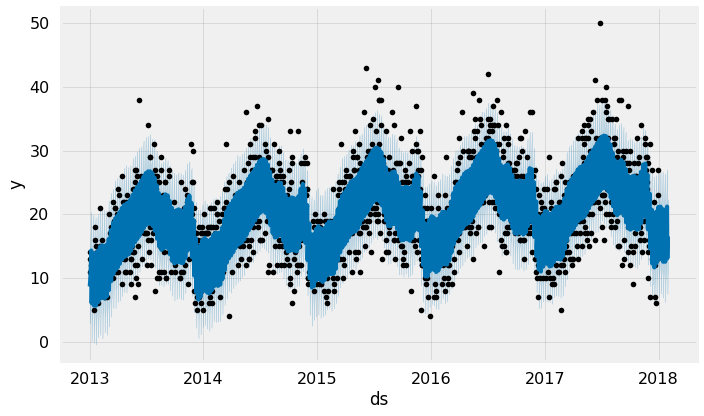

In [72]:
# model
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.fit(df)

# forecast
future = m.make_future_dataframe(periods = 31)
forecast = m.predict(future)

m.plot(forecast);

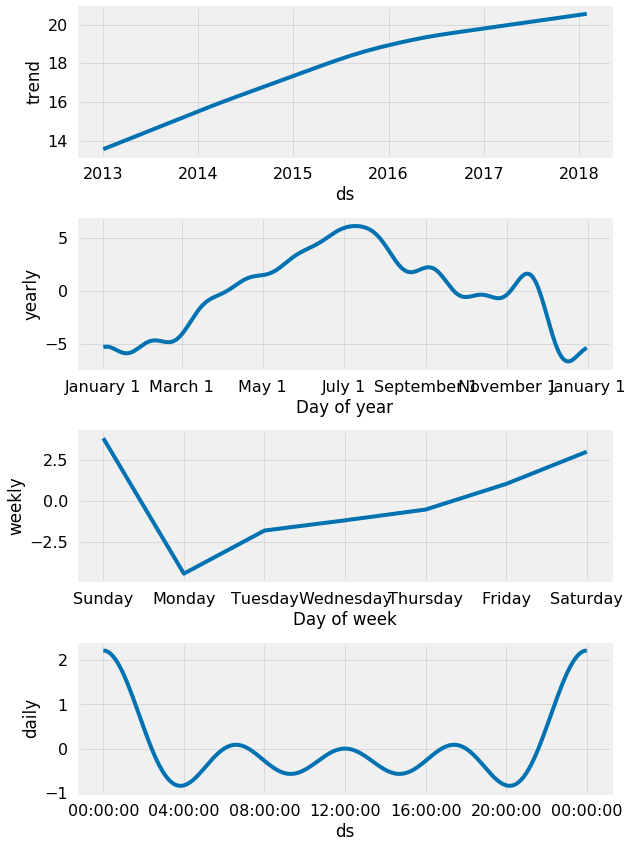

In [104]:
m.plot_components(forecast);
# really interesting the decomposition of the ts


*  trend seems correct
*  yearly season suggests that this is not a "winter" store, since sales drops around colder months
* weekly season seems ok, at least expected
* daily season is weird, it doesn't feel correct to have more sales during the night hours.

In [93]:
# confront visually prediction and actual
df_plot = pd.concat([df.ds, forecast.yhat, df.y], axis=1)
df_plot.head()
df_plot = df_plot.melt(id_vars='ds')

Text(0.5,1,'Prediction VS Actual')

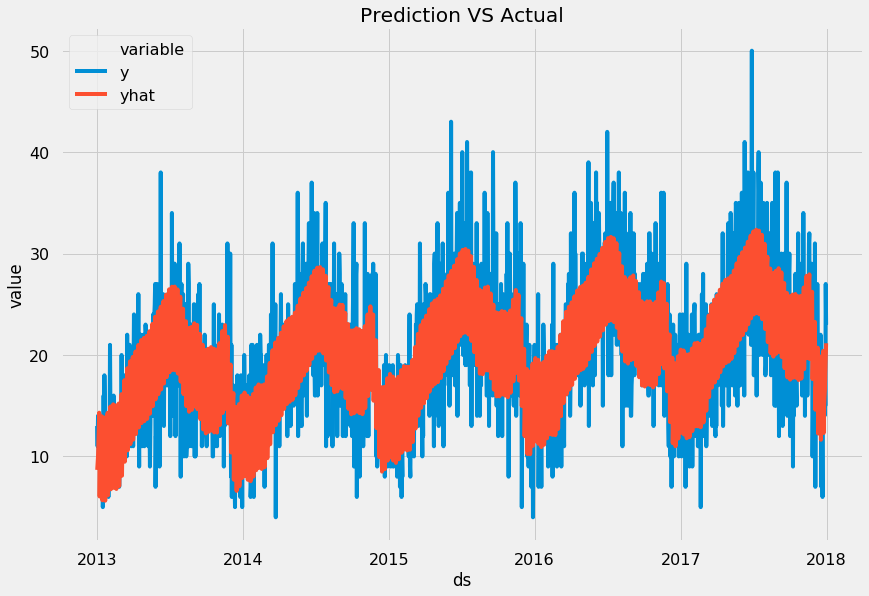

In [102]:
# plot
sns.lineplot(x='ds', y='value', hue='variable', hue_order=['y', 'yhat'],data=df_plot).set_title("Prediction VS Actual")

Text(0.5,1,'Focus on year 2017')

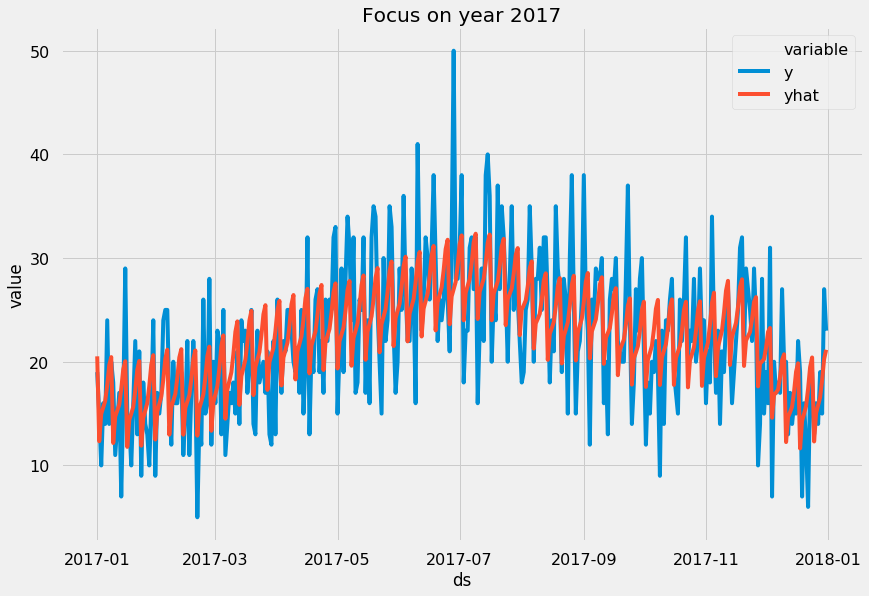

In [103]:
# plot zoom
sns.lineplot(x='ds', y='value', hue='variable', hue_order=['y', 'yhat'],data=df_plot[df_plot.ds >= '2017-01-01']).set_title("Focus on year 2017")
# not bad for an automatic model. The seasonality seems to be easy to pick. 
# the real challenge would be to reach for those peaks.

### What about other items? I suppose they are different, do they show different trends?

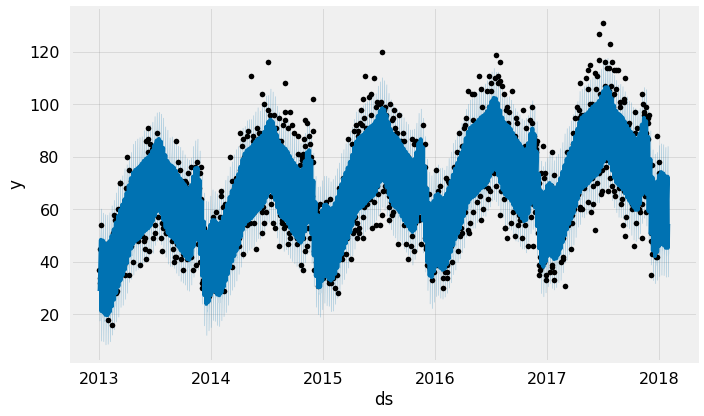

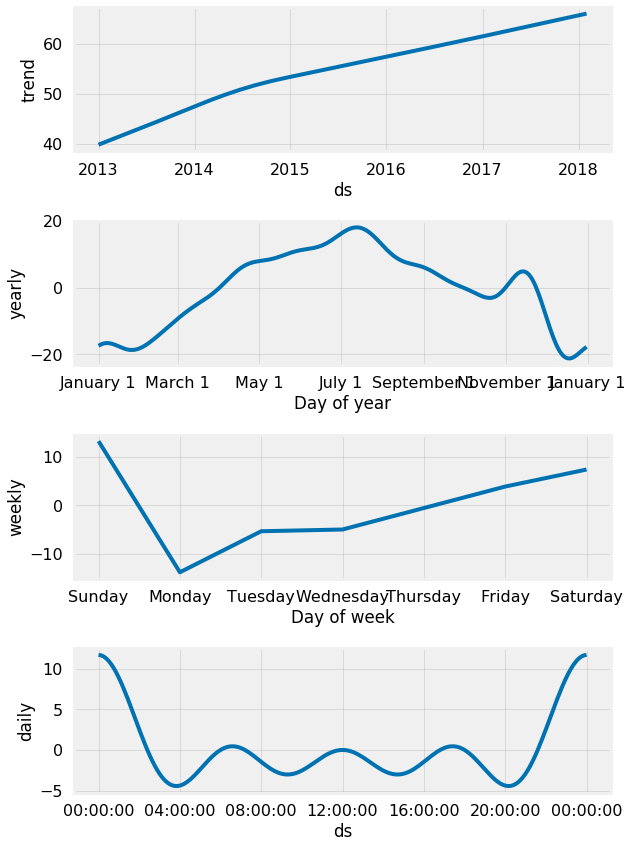

In [106]:
df = train[(train.store==1) & (train.item==10)].copy()
df.drop(['store', 'item'], axis=1, inplace=True)
df.columns = ['ds', 'y']
df.head()
# model
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.fit(df)

# forecast
future = m.make_future_dataframe(periods = 31)
forecast = m.predict(future)

m.plot(forecast);
m.plot_components(forecast);
# really interesting the decomposition of the ts
# not so different trends here